# **Data Aquistion**


This notebook downloads the required data for state-of-the-art LCZ Classification:

1. Setup the project by defining the city of interest
2. City boundary polygon download from OpenStreetMap 
3. Sentinel-2 imagery download using AWS S3
4. ALOS DSM 30m download from Google Earth Engine
5. Impervious Surface Area download from Google Earth Engine 
6. Tree Canopy Height download from Google Earth Engine
7. Building Height download from NRCan

## **1. Project Setup**


This code block imports the necessery Python libraries

### 1.1. Import Libraries

In [1]:
%load_ext autoreload
%autoreload 

import sys
import os

# Add the module's parent directory to sys.path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from lcz_classification.config import  *
from lcz_classification.dataset import ee_download, fetch_metadata
from lcz_classification.util import tiles_from_bbox, kml_to_gdf
import geopandas as gpd
import matplotlib.pyplot as plt
import ee
import numpy as np
import pandas as pd


- Parent directory for Cairo already exists, retrievine folder paths...
- Folder paths for Cairo retrieved.


#### 1.2. Setup Directories

<Axes: >

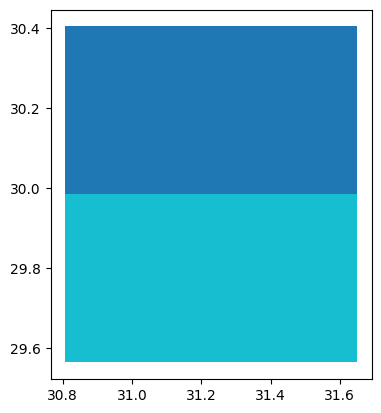

In [2]:

study_area=fetch_metadata('STUDY_AREA')

bounds=list(study_area.total_bounds)

s2_tiles=fetch_metadata('S2_TILES')

tiles_gdf=tiles_from_bbox(bounds, tile_dims=TILE_DIMS).sort_values('tile_id')
tiles_gdf.plot('tile_id')
# tiles_gdf=tiles_gdf[tiles_gdf.tile_id == 'B3']

# 2.1. Get Study Area

In [3]:
study_area.explore(
                style=dict(
                    fill = False,
                    color='red'
                ),
)

### 1.3 Authenticate Google Earth Engine

In [4]:
EE_PROJECT_ID=input('Enter Your Google Earth Engine Project ID:')

if ee.Authenticate() == True:
    ee.Initialize(project=EE_PROJECT_ID)    
else:
    ee.Authenticate(force = True)
    ee.Initialize(project=EE_PROJECT_ID)    

# **3. Sentinel-2 Download**

Using download_tiles function, Sentinel-2 data is downloaded from the AWS S3 Bucket using boto3. The city boundary polygon and data range are used to derive matching scenes withiin the sentinel-2 database.

https://registry.opendata.aws/sentinel-2/


In [5]:
import geemap


# START_DATE , END_DATE= ('2023-05-01' ,'2023-05-30')



images=list()
# iterate throught tile geometries generated with tiles_from_bbox()
for idx, tile in tiles_gdf.iterrows():

     tile_id = tile.tile_id
     print(f"Retrieving ImageCollection for Tile {tile_id}")
     print(f"===================================================")
     ee_geom= ee.Geometry.Rectangle(tile.geometry.bounds)
     

     # Get ImageCollection filtered by date range, cloud percentage and first tile
     col=(ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
          .filterBounds(ee_geom)
          .filterDate(START_DATE, END_DATE)
          .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',5))
          # .map(mask_s2_clouds)
          )
     
     features = col.getInfo()['features']
     print(f"- Number of Features: {len(features)}")
     # Retrieve Least Cloudy Images from the Collection

     # Mosaic Images of Least Cloudy Collection and Clip to Bounds 
     image=col.mean()
 
     
     images.append(image)
     
     # Get Matching Tile IDs
     # break
     print(f'Downloading Images for Tile: {tile_id}')
     # Iterate through target S2 bands and export
     for band in S2_TARGET_BANDS:
          out_dir = f"{S2_RAW}/T{tile_id}"
          filename=f"{out_dir}/{band}.tif"
          if os.path.exists(out_dir) == False:
               os.mkdir(out_dir)
               
          if os.path.exists(filename) == False:
               print(f"- Downloading ee.Image for tile {tile_id} and Band {band}")
               ee_band=band.replace('0','')
               # Export Image using geemap
               geemap.ee_export_image(
                         image.select(ee_band),
                         filename=filename,
                         scale=CELL_RESOLUTION,
                         file_per_band=False,
                         crs='EPSG:4326', 
                         region = ee_geom
                    )
          else:
               print(f"- GeoTIFF for Tile {tile_id} Band {band} already downloaded")

     print(f"===================================================")
     


Retrieving ImageCollection for Tile A1
- Number of Features: 21
- GeoTIFF for Tile A1 Band B02 already downloaded
- GeoTIFF for Tile A1 Band B03 already downloaded
- GeoTIFF for Tile A1 Band B04 already downloaded
- GeoTIFF for Tile A1 Band B05 already downloaded
- GeoTIFF for Tile A1 Band B06 already downloaded
- GeoTIFF for Tile A1 Band B07 already downloaded
- GeoTIFF for Tile A1 Band B8A already downloaded
- GeoTIFF for Tile A1 Band B11 already downloaded
- GeoTIFF for Tile A1 Band B12 already downloaded
Retrieving ImageCollection for Tile A2
- Number of Features: 43
- GeoTIFF for Tile A2 Band B02 already downloaded
- GeoTIFF for Tile A2 Band B03 already downloaded
- GeoTIFF for Tile A2 Band B04 already downloaded
- GeoTIFF for Tile A2 Band B05 already downloaded
- GeoTIFF for Tile A2 Band B06 already downloaded
- GeoTIFF for Tile A2 Band B07 already downloaded
- GeoTIFF for Tile A2 Band B8A already downloaded
- GeoTIFF for Tile A2 Band B11 already downloaded
- GeoTIFF for Tile A2 

## **4. DSM from ALOS 30m**

In [6]:
import geemap

def ee_get_image(col_id, band,bbox):
    
    geom=ee.Geometry.Rectangle(bbox)

    asset_type=ee.data.getInfo(col_id)['type']
    print(asset_type)
    if asset_type == 'IMAGE_COLLECTION':
        image=ee.ImageCollection(col_id).filterBounds(geom).mean().select(band)
    else:
        image=ee.Image(col_id).select(band).clip(geom)

    image_id = col_id.replace('/','_') + f'_{band}'
   
    return image, image_id


def ee_download_tiled_image(image, image_id,tiles_gdf, scale, output_dir,):

    for idx, tile in tiles_gdf.iterrows():
        tile_id=tile.tile_id
        bbox=tile.geometry.bounds
        bbox_geom=ee.Geometry.Rectangle(bbox)
        filename=f"{output_dir}/{image_id}_{tile_id}_{scale}m.tif"
        if os.path.exists(filename) == False:

            geemap.ee_export_image(
                image,
                filename=filename,
                scale=scale,
                file_per_band=False,
                crs='EPSG:4326', 
                region = bbox_geom
            )
        print(f"{filename} Already Exists")
        print(f"Downloaded Image: {image_id}_{tile_id}_{scale}m.tif")

In [7]:
# Download ALOS DSM Data from Google Earth Engine

image,image_id=ee_get_image(
            col_id="JAXA/ALOS/AW3D30/V3_2",
            band="DSM",
            bbox = bounds, 
            )

ee_download_tiled_image(image,image_id,tiles_gdf, CELL_RESOLUTION,DSM_RAW)


IMAGE_COLLECTION
../data/cairo/raw/alos_dsm_30m/JAXA_ALOS_AW3D30_V3_2_DSM_A1_30m.tif Already Exists
Downloaded Image: JAXA_ALOS_AW3D30_V3_2_DSM_A1_30m.tif
../data/cairo/raw/alos_dsm_30m/JAXA_ALOS_AW3D30_V3_2_DSM_A2_30m.tif Already Exists
Downloaded Image: JAXA_ALOS_AW3D30_V3_2_DSM_A2_30m.tif


## **5. Impervious Surface Area**

In [8]:
# # Download Impervious Surface Area from Google Earth Engine

# ee_download(
#             asset_id="projects/sat-io/open-datasets/GISD30_1985_2020",
#             bands=["b1"],
#             bbox =bounds, 
#             output_dir=IS_RAW,
#             scale=CELL_RESOLUTION,
#             tile_dims=tile_dims
#             )

## **6. Tree Canopy Height**

In [9]:
# Download Canopy Height from Google Earth Engine

ch_tiles=tiles_from_bbox(bounds,tile_dims=(2,2))
image,image_id=ee_get_image(
            col_id="users/nlang/ETH_GlobalCanopyHeight_2020_10m_v1",
            band="b1",
            bbox = bounds, 
            )

ee_download_tiled_image(image,image_id,ch_tiles, 10,CH_RAW)
# ee_download(
#             asset_id="users/nlang/ETH_GlobalCanopyHeight_2020_10m_v1",
#             bands=["b1"],
#             bbox = bounds, 
#             output_dir=CH_RAW,
#             scale=10,
#             tile_dims=(4,4)
#             )

IMAGE
../data/cairo/raw/canopy_height/users_nlang_ETH_GlobalCanopyHeight_2020_10m_v1_b1_A1_10m.tif Already Exists
Downloaded Image: users_nlang_ETH_GlobalCanopyHeight_2020_10m_v1_b1_A1_10m.tif
../data/cairo/raw/canopy_height/users_nlang_ETH_GlobalCanopyHeight_2020_10m_v1_b1_A2_10m.tif Already Exists
Downloaded Image: users_nlang_ETH_GlobalCanopyHeight_2020_10m_v1_b1_A2_10m.tif
../data/cairo/raw/canopy_height/users_nlang_ETH_GlobalCanopyHeight_2020_10m_v1_b1_B1_10m.tif Already Exists
Downloaded Image: users_nlang_ETH_GlobalCanopyHeight_2020_10m_v1_b1_B1_10m.tif
../data/cairo/raw/canopy_height/users_nlang_ETH_GlobalCanopyHeight_2020_10m_v1_b1_B2_10m.tif Already Exists
Downloaded Image: users_nlang_ETH_GlobalCanopyHeight_2020_10m_v1_b1_B2_10m.tif


## **7. Building Height Data**

Download building height data for British Columbia from the NRCan Website- https://ftp.maps.canada.ca/pub/nrcan_rncan/extraction/auto_building/fgdb/

In [10]:


col = ee.ImageCollection('GOOGLE/Research/open-buildings-temporal/v1')
# // Get latest 2 years
image=col.filterDate('2020-01-01', '2020-12-31').mean().select('building_height')

bh_tiles=tiles_from_bbox(bounds,tile_dims=(3,3))
ee_download_tiled_image(image,'building_heights_2020',bh_tiles, scale=10,output_dir=BH_RAW)
# for idx, tile in tiles_gdf.iterrows():

#     tile_id = tile.tile_id
#     print(f"Retrieving ImageCollection for Tile {tile_id}")
#     print(f"===================================================")
#     ee_geom= ee.Geometry.Rectangle(tile.geometry.bounds)



../data/cairo/raw/building_height/building_heights_2020_A1_10m.tif Already Exists
Downloaded Image: building_heights_2020_A1_10m.tif
../data/cairo/raw/building_height/building_heights_2020_A2_10m.tif Already Exists
Downloaded Image: building_heights_2020_A2_10m.tif
../data/cairo/raw/building_height/building_heights_2020_A3_10m.tif Already Exists
Downloaded Image: building_heights_2020_A3_10m.tif
../data/cairo/raw/building_height/building_heights_2020_B1_10m.tif Already Exists
Downloaded Image: building_heights_2020_B1_10m.tif
../data/cairo/raw/building_height/building_heights_2020_B2_10m.tif Already Exists
Downloaded Image: building_heights_2020_B2_10m.tif
../data/cairo/raw/building_height/building_heights_2020_B3_10m.tif Already Exists
Downloaded Image: building_heights_2020_B3_10m.tif
../data/cairo/raw/building_height/building_heights_2020_C1_10m.tif Already Exists
Downloaded Image: building_heights_2020_C1_10m.tif
../data/cairo/raw/building_height/building_heights_2020_C2_10m.tif Al

## MODIS NIGHTIME LST

In [12]:
start=ee.Date('2023-07-01')
end=ee.Date('2023-07-30')

mod_col=ee.ImageCollection('MODIS/061/MOD11A1').filterDate(start,end).select('LST_Night_1km')
mod_image=mod_col.mean()
import geemap
geemap.ee_export_image(
                mod_image,
                filename='../data/toronto/raw/air_temp/mean_night_temp_30m_202307.tif',
                scale=30,
                file_per_band=False,
                crs='EPSG:4326', 
                region = [-79.65855698,  43.54089266, -79.18514482,  43.93255813]
            )

Generating URL ...
Please wait ...


KeyboardInterrupt: 